In [2]:
from pandas import read_csv
import pandas as pd
import matplotlib.pyplot as plt
#from pyspec_ssmehta.parser.pymzl.msms_spectrum import MSMSSpectrum
from pyspec_ssmehta.similarity.nominal_similarity import *
from pyspec_ssmehta.similarity.nominal_similarity import _transform_spectrum_tuple
from pyspec_ssmehta.similarity.nominal_similarity import _transform_spectrum
import numpy as np
import seaborn as sns
import time


In [1]:
pip install -e "git+https://github.com/metabolomics-us/pyspec.git@similarity#egg=version_subpkg&subdirectory=pyspec" --no-deps

Obtaining version_subpkg from git+https://github.com/metabolomics-us/pyspec.git@similarity#egg=version_subpkg&subdirectory=pyspec
  Updating ./src/version-subpkg clone (to revision similarity)
  Running command git fetch -q --tags
  Running command git reset --hard -q 3e7e4ab0e4c17e0c59aa07d90800c1dddbcac162
  Found existing installation: pyspec 0.0.0
    Uninstalling pyspec-0.0.0:
      Successfully uninstalled pyspec-0.0.0
  Running setup.py develop for pyspec
Note: you may need to restart the kernel to use updated packages.


In [ ]:
data = read_csv('result.csv')
data.sample(frac=1)

In [107]:
class spectra_similarity:
    def __init__(self, filename, which_bins = None, shuffle = False):
        '''
        intensity_consensus: 
        A dictionary with bin number as the key, the value is a 2 dimension array. 
        Each row represents a consensus spectrum
        '''
        self.filename = filename
        
        self.data = read_csv(self.filename)
        if shuffle:
            self.data = self.data.sample(frac=1)
        if which_bins is None:
            self.bins = np.unique(self.data.bin_id)
        else:
            self.bins = which_bins

        data_by_bin = {}
        for i in self.bins:
            data_by_bin[i] = self.data[self.data.bin_id == i] 
            
        self.intensity = {}
        self.intensity_consensus = {}
        self.n_spectrum = {}

        for i in self.bins:
            self.n_spectrum[i] = data_by_bin[i].shape[0]
            self.intensity[i] = np.zeros([self.n_spectrum[i], (500-85+1)])
            for j in range(self.n_spectrum[i]):
                spectrum = data_by_bin[i].spectra.iloc[j]
                spectrum_tuple = _transform_spectrum_tuple(spectrum)
                for k in spectrum_tuple:
                    if k[0] <= 500:
                        self.intensity[i][j,int(k[0])-85] = k[1]

            self.intensity_consensus[i] = np.zeros([self.n_spectrum[i], (500-85+1)])
            for j in range((500-85+1)):
                self.intensity_consensus[i][:,j] = np.cumsum(self.intensity[i][:,j])

    def array_to_spec(self, array):
        spec = {}

        for i, y_val in enumerate(array):
            if y_val > 0:
                spec[85 + i] = y_val

        return spec

    def compute_score(self,
                      ref_index = 0,
                      similarity_method = "cosine_similarity",
                      tolerance = 0.01):
        self.score = {}
        for i in self.bins:
            if ref_index < self.n_spectrum[i]:
                spec_ref = self.array_to_spec(self.intensity[i][ref_index,:])
                score_temp = []
                for j in range(self.n_spectrum[i]):
                    spec = self.array_to_spec(self.intensity_consensus[i][j,:])  
                    if similarity_method == "spectral_similarity":        
                        spec_ref_MSMS = MSMSSpectrum(spec_ref, precursor_mz = self.intensity_consensus[i][0,0])
                        spec_MSMS = MSMSSpectrum(spec, precursor_mz = self.intensity_consensus[i][j,0])
                        score_temp.append(spec_ref_MSMS.spectral_similarity(spec_MSMS, tolerance))
                    elif similarity_method == 'cosine_similarity':
                        score_temp.append(cosine_similarity(spec_ref, spec))
                    elif similarity_method == 'composite_similarity':
                        score_temp.append(composite_similarity(spec_ref, spec))
                self.score[i] = np.array(score_temp)
            else: 
                self.score[i] = np.zeros((self.n_spectrum[i],))
                
    def cross_ref(self, 
                  similarity_method = "cosine_similarity ", 
                  tolerance = 0.01):
        self.score_matrix = {}
        
        n_spectrum_max = np.max(list(spectra_out.n_spectrum.values()))
        score_arrays_collection = {}
        
        for j in range(n_spectrum_max):
            self.compute_score(ref_index = j)
            for i in self.bins:
                if j == 0:
                    score_arrays_collection[i] = []
                if j < self.n_spectrum[i]:
                    score_arrays_collection[i].append(self.score[i])
        
        for i in self.bins:
            self.score_matrix[i] = np.vstack(score_arrays_collection[i])

        self.score_mid_val = {}            
        self.score_median = {}
        self.score_sd = {}  
        self.score_mean = {}
        
        for i in self.bins:   
            max_val = np.max(self.score_matrix[i], axis = 0)
            min_val = np.min(self.score_matrix[i], axis = 0)
            mid_val = (max_val+min_val)/2
            self.score_mid_val[i] = mid_val
            self.score_median[i] = np.median(self.score_matrix[i], axis = 0)
            self.score_sd[i] = np.std(self.score_matrix[i], axis = 0)
            self.score_mean[i] = np.mean(self.score_matrix[i], axis = 0)

    def similarity_plot(self, metric = "mean"):
        if metric == "mid_val":
            for i in self.bins:
                x = list(range(1,self.n_spectrum[i]+1))
                plt.plot(x, self.score_mid_val[i], label=f'bin: {i}')
                plt.xlabel('Count of spectra in the consensus spectra') 
                plt.ylabel('Score') # y axis is score
                plt.ylim((0.8,1))
                plt.title('Mid-Value')
                plt.legend()
                plt.rc('font', size=15) 
                figure_name = 'mid_val_score_bin_' + str(i) + '.png'
                plt.savefig(figure_name, bbox_inches='tight')
                plt.show()    
                plt.close()
        elif metric == "median":
            for i in self.bins:
                x = list(range(1,self.n_spectrum[i]+1))
                plt.plot(x, self.score_median[i], label=f'bin: {i}')
                plt.xlabel('Count of spectra in the consensus spectra') 
                plt.ylabel('Score') # y axis is score     
                plt.ylim((0.8,1))                
                plt.title('Median')
                plt.legend()
                plt.rc('font', size=15) 
                figure_name = 'median_score_bin_' + str(i) + '.png'
                plt.savefig(figure_name, bbox_inches='tight')
                plt.show()    
                plt.close()
        elif metric == "std":
            for i in self.bins:
                x = list(range(1,self.n_spectrum[i]+1))
                plt.plot(x, self.score_sd[i], label=f'bin: {i}')
                plt.xlabel('Count of spectra in the consensus spectra') 
                plt.ylabel('Score') # y axis is score
                plt.title('Standard Deviation')
                plt.legend()
                plt.rc('font', size=15) 
                figure_name = 'std_score_bin_' + str(i) + '.png'
                plt.savefig(figure_name, bbox_inches='tight')
                plt.show()    
                plt.close()
        elif metric == "mean":
            for i in self.bins:
                x = list(range(1,self.n_spectrum[i]+1))
                plt.plot(x, self.score_mean[i], label=f'bin: {i}')
                plt.xlabel('Count of spectra in the consensus spectra') 
                plt.ylabel('Score') # y axis is score
                plt.ylim((0.8,1))                
                plt.title('Mean for Bin ' + str(i))
                #plt.legend()
                plt.rc('font', size=15) 
                figure_name = 'mean_score_bin_' + str(i) + '.png'
                plt.savefig(figure_name, bbox_inches='tight')
                plt.show()    
                plt.close()

    def plot_metrics(self, selected_bin = '18,223'):
        plt.rc('font', size=15) 
        plt.figure(figsize=(20,10))
        x = list(range(1,self.n_spectrum[selected_bin]+1))
        for j in range(len(x)):
            plt.plot(x, self.score_matrix[selected_bin][j], 'lightgrey')
        plt.plot(x, self.score[selected_bin], 'brown', label='mid value') 
        plt.plot(x, self.score_median[selected_bin], 'r', label='median')   
        plt.plot(x, self.score_mean[selected_bin], 'b', label='mean') 
        plt.plot(x, self.score_sd[selected_bin], 'g', label='standard devation') 
        plt.xlabel('Count of spectra in the consensus spectra') 
        plt.ylabel('Score') # y axis is score
        plt.title(f'Similarity Curves with different\
        reference spectrum for bin: {selected_bin}')
        plt.legend()
        plt.show()

In [108]:
spectra_out = spectra_similarity(filename = 'data.csv', shuffle = True)

In [66]:
# spectra_out.data
# spectra_out.bins
# spectra_out.n_spectrum
# spectra_out.intensity_consensus

In [79]:
# start_time = time.time()
# spectra_out.compute_score(ref_index = 6)
# end_time = time.time()
# end_time-start_time

2.9802322387695312e-05

In [109]:
start_time = time.time()
spectra_out.cross_ref()
end_time = time.time()
end_time-start_time

234.26619601249695

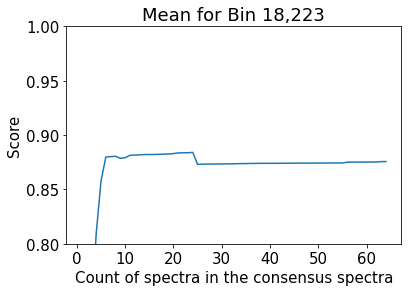

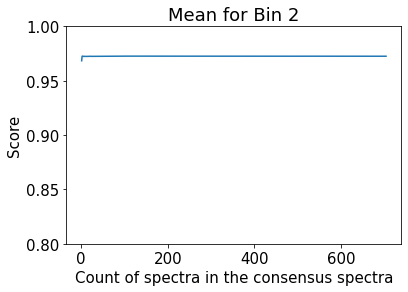

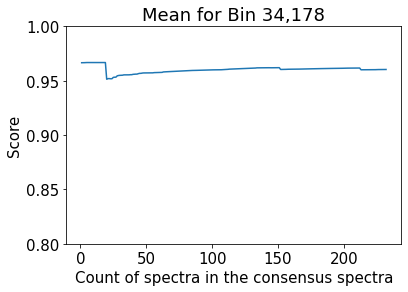

In [110]:
spectra_out.score
spectra_out.similarity_plot()
# get all the plots

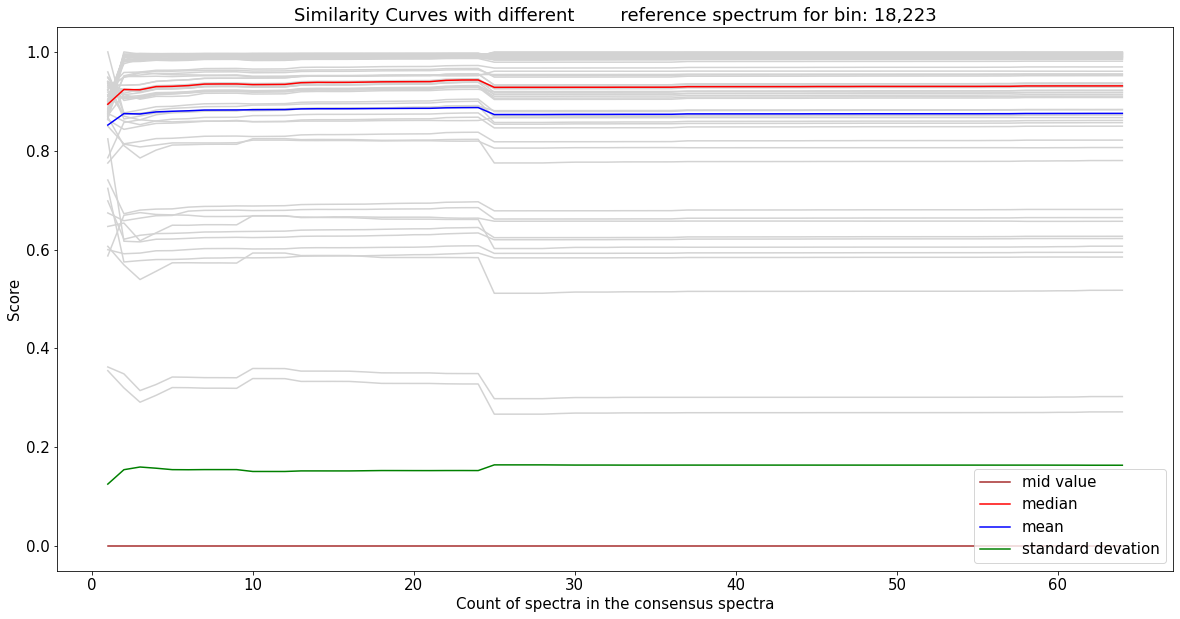

In [70]:
spectra_out.plot_metrics()

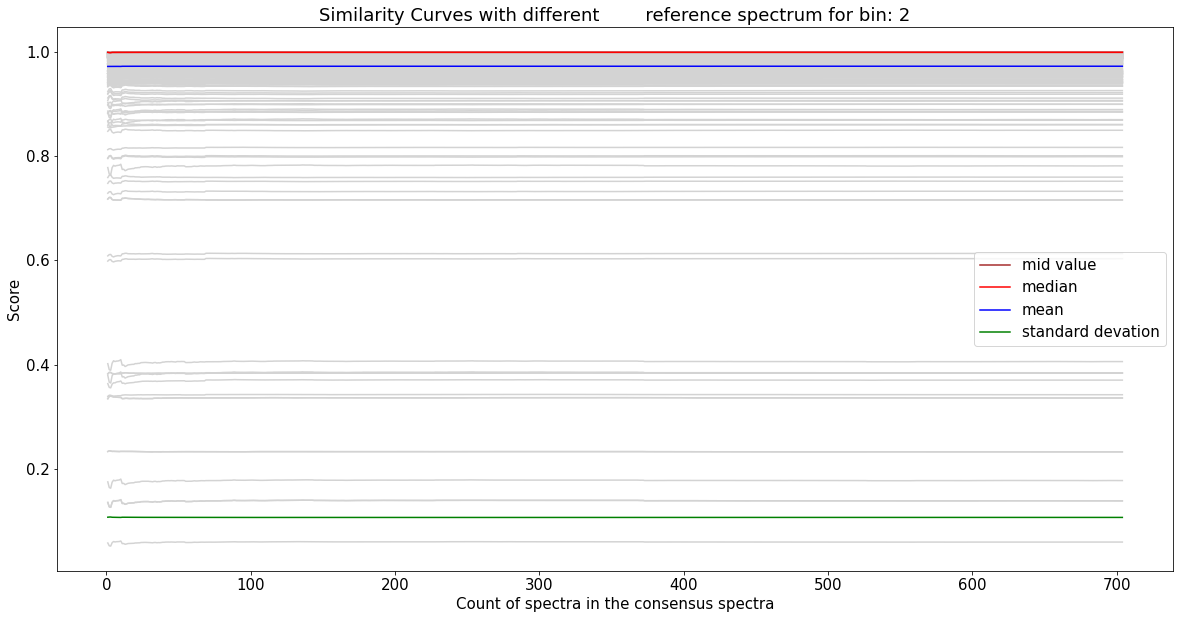

In [71]:
spectra_out.plot_metrics('2')

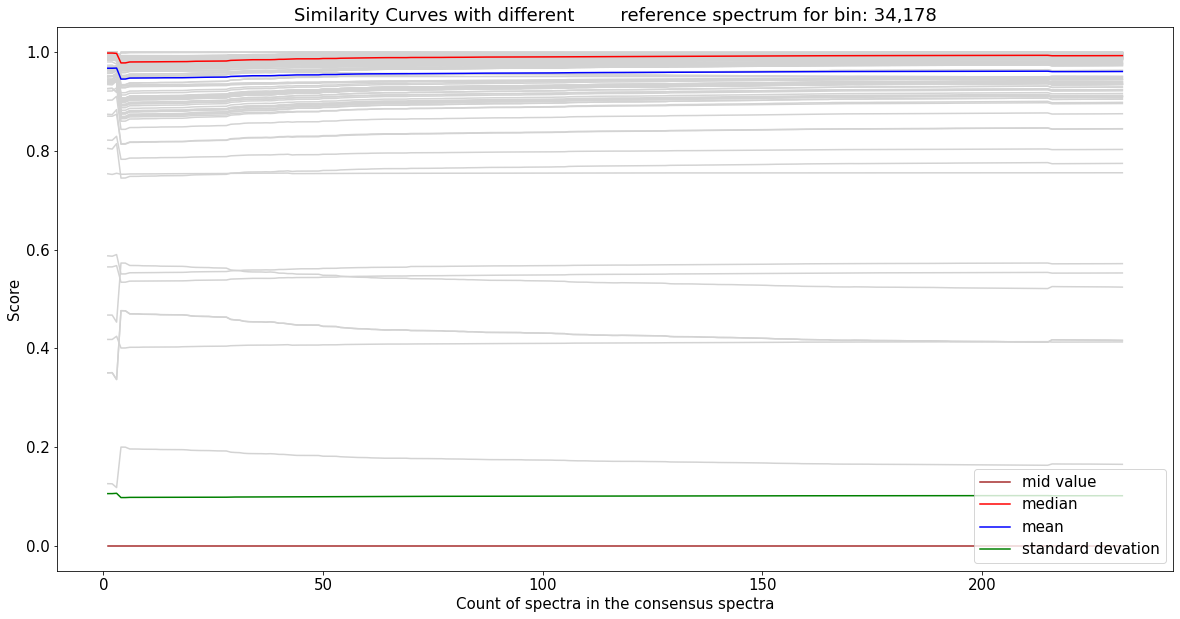

In [72]:
spectra_out.plot_metrics('34,178')

In [17]:
i = '18,223'

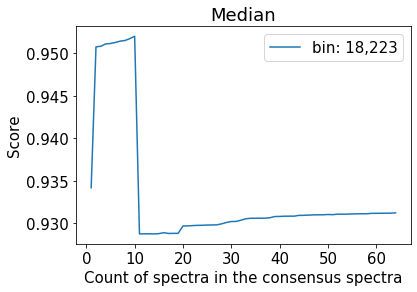

In [18]:
x = list(range(1,spectra_out.n_spectrum[i]+1))
plt.plot(x, spectra_out.score_median[i], label=f'bin: {i}')
plt.xlabel('Count of spectra in the consensus spectra') 
plt.ylabel('Score') # y axis is score
plt.title('Median')
plt.legend()
#plt.axis([85, 500, min(y_values_min), max(y_values_max)])
plt.show()

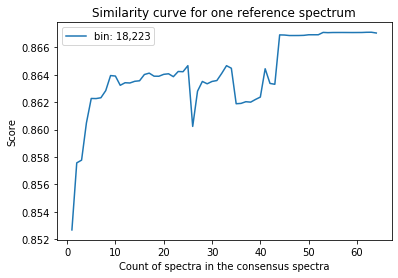

In [58]:
x = list(range(1,spectra_out.n_spectrum[i]+1))
plt.plot(x, spectra_out.score_matrix[i][3], label=f'bin: {i}')
plt.xlabel('Count of spectra in the consensus spectra') 
plt.ylabel('Score') # y axis is score
plt.title('Similarity curve for one reference spectrum')
plt.legend()
#plt.axis([85, 500, min(y_values_min), max(y_values_max)])
plt.show()

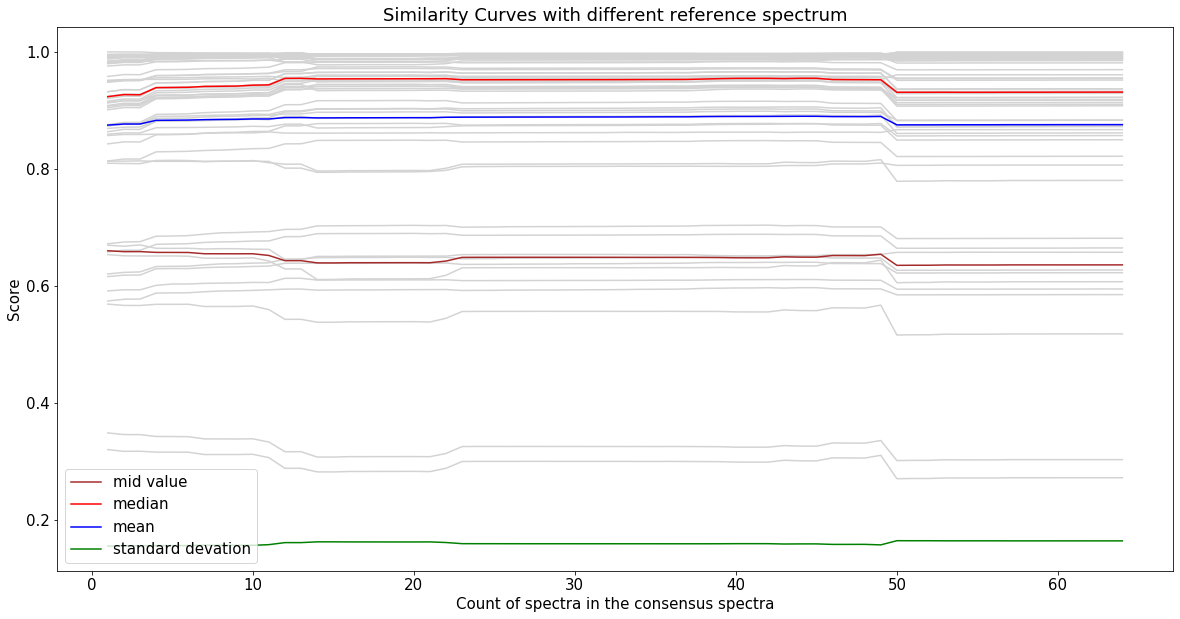

In [96]:
plt.rc('font', size=15) 
plt.figure(figsize=(20,10))
x = list(range(1,spectra_out.n_spectrum[i]+1))
for j in range(len(x)):
    plt.plot(x, spectra_out.score_matrix[i][j], 'lightgrey')
plt.plot(x, spectra_out.score[i], 'brown', label='mid value') 
plt.plot(x, spectra_out.score_median[i], 'r', label='median')   
plt.plot(x, spectra_out.score_mean[i], 'b', label='mean') 
plt.plot(x, spectra_out.score_sd[i], 'g', label='standard devation') 
plt.xlabel('Count of spectra in the consensus spectra') 
plt.ylabel('Score') # y axis is score
plt.title('Similarity Curves with different reference spectrum')
plt.legend()
plt.show()

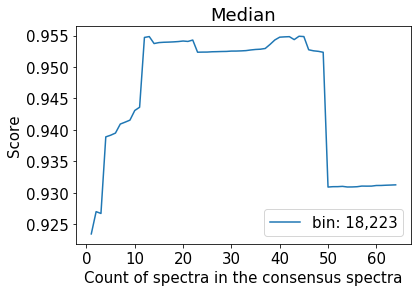

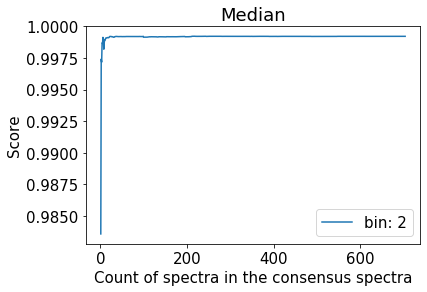

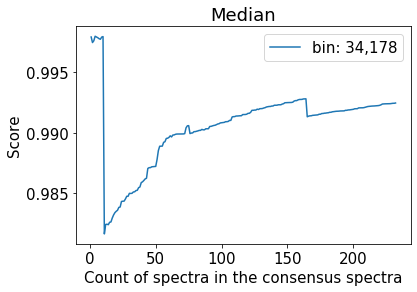

In [97]:
spectra_out.similarity_plot(metric = "median")

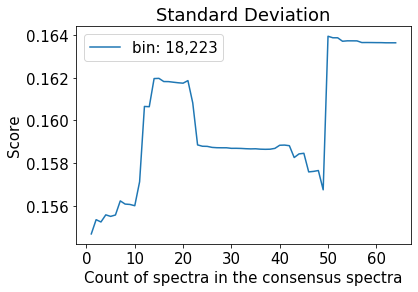

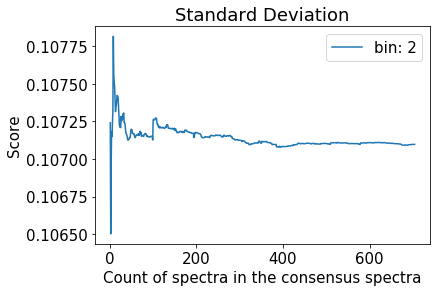

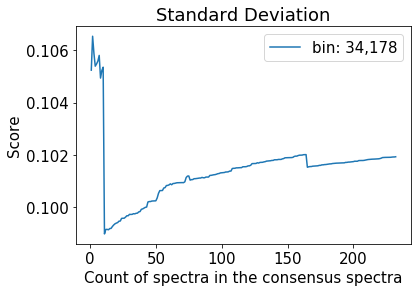

In [98]:
spectra_out.similarity_plot(metric = "std")

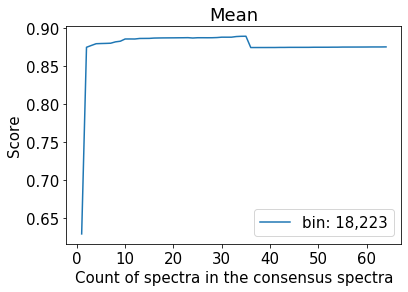

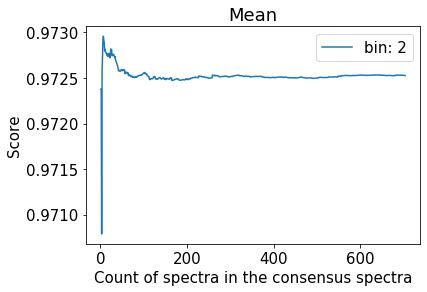

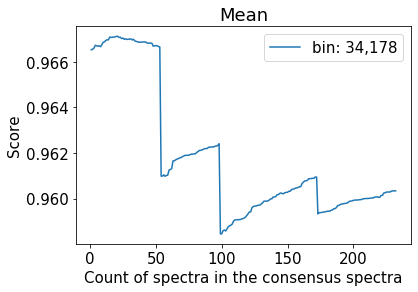

In [28]:
spectra_out.similarity_plot(metric ="mean")

In [5]:
spectra_out.n_spectrum

{'18,223': 64, '2': 704, '34,178': 232}

In [ ]:
spectra_out.cross_ref()

In [99]:
spectra_out.compute_score()
score0 = spectra_out.score
spectra_out.compute_score(ref_index = 1)
score1 = spectra_out.score

In [100]:
spectra_out.n_spectrum

{'18,223': 64, '2': 704, '34,178': 232}

In [101]:
spectra_out.cross_ref()

In [ ]:
score0['2'].shape

In [ ]:
np.vstack([score0['2'], score1['2']])

In [ ]:
a = np.vstack((score0['2'], score1['2']))

In [ ]:
max_array = np.max(a, axis = 0)
min_array = np.min(a, axis = 0)
(max_array + min_array)/2

In [ ]:
data = read_csv('data.csv')
bins = np.unique(data.bin_id)

data_by_bin = {}
for i in bins:
    data_by_bin[i] = data[data.bin_id == i]

intensity = {}
intensity_consensus = {}
n_spectrum = {}

for i in bins:
    n_spectrum[i] = data_by_bin[i].shape[0]
    intensity[i] = np.zeros([n_spectrum[i], (500-85+1)])
    for j in range(n_spectrum[i]):
        spectrum = data_by_bin[i].spectra.iloc[j]
        spectrum_tuple = _transform_spectrum_tuple(spectrum)
        for k in spectrum_tuple:
            if k[0] <= 500:
                intensity[i][j,int(k[0])-85] = k[1]
    
    intensity_consensus[i] = np.zeros([n_spectrum[i], (500-85+1)])
    for j in range((500-85+1)):
        intensity_consensus[i][:,j] = np.cumsum(intensity[i][:,j])

In [ ]:
def array_to_spec(array):
    spec = ""
    count = 85
    for y_val in array:
        spec = spec + str(count) + ":" + str(y_val) + " "
        count += 1
    return(spec)

In [ ]:
def similarity_plot(bins, n_spectrum, intensity_consensus, similarity_method, tolerance = 0.01):
    score = {}
    for i in bins:
        spec_ref = array_to_spec(intensity_consensus[i][0,:])
        score_temp = []
        for j in range(n_spectrum[i]):
            spec = array_to_spec(intensity_consensus[i][j,:])  
            if similarity_method == "spectral_similarity":        
                spec_ref_MSMS = MSMSSpectrum(spec_ref, precursor_mz = intensity_consensus[i][0,0])
                spec_MSMS = MSMSSpectrum(spec, precursor_mz = intensity_consensus[i][j,0])
                score_temp.append(spec_ref_MSMS.spectral_similarity(spec_MSMS, tolerance))
            elif similarity_method == 'cosine_similarity':
                score_temp.append(cosine_similarity(spec_ref, spec))
            elif similarity_method == 'composite_similarity':
                score_temp.append(composite_similarity(spec_ref, spec))
        score[i] = np.array(score_temp)
     
    for i in bins:
        x = list(range(1,n_spectrum[i]+1))
        plt.plot(x, score[i], label=f'bin: {i}')
        plt.xlabel('Count of spectra in the consensus spectra') 
        plt.ylabel('Score') # y axis is score
        plt.legend()
        #plt.axis([85, 500, min(y_values_min), max(y_values_max)])
        plt.show()
        
    return(score)

In [ ]:
def compute_score(bins, n_spectrum, intensity_consensus, similarity_method, tolerance = 0.01):
    score = {}
    for i in bins:
        spec_ref = array_to_spec(intensity_consensus[i][0,:])
        score_temp = []
        for j in range(n_spectrum[i]):
            spec = array_to_spec(intensity_consensus[i][j,:])  
            if similarity_method == "spectral_similarity":        
                spec_ref_MSMS = MSMSSpectrum(spec_ref, precursor_mz = intensity_consensus[i][0,0])
                spec_MSMS = MSMSSpectrum(spec, precursor_mz = intensity_consensus[i][j,0])
                score_temp.append(spec_ref_MSMS.spectral_similarity(spec_MSMS, tolerance))
            elif similarity_method == 'cosine_similarity':
                score_temp.append(cosine_similarity(spec_ref, spec))
            elif similarity_method == 'composite_similarity':
                score_temp.append(composite_similarity(spec_ref, spec))
        score[i] = np.array(score_temp)
    return(score)

In [ ]:
def similarity_plot(n_spectrum, score):
    for i in bins:
        x = list(range(1,n_spectrum[i]+1))
        plt.plot(x, score[i], label=f'bin: {i}')
        plt.xlabel('Count of spectra in the consensus spectra') 
        plt.ylabel('Score') # y axis is score
        plt.legend()
        #plt.axis([85, 500, min(y_values_min), max(y_values_max)])
        plt.show()

In [ ]:
score1 = compute_score(bins, n_spectrum, intensity_consensus, 'spectral_similarity', tolerance = 0.0001)
score1

In [ ]:
score1 = similarity_plot(bins, n_spectrum, intensity_consensus, 'spectral_similarity', tolerance = 0.0001)

In [ ]:
score2 = similarity_plot(bins, n_spectrum, intensity_consensus, 'cosine_similarity')

In [ ]:
score3 = similarity_plot(bins, n_spectrum, intensity_consensus, 'composite_similarity')

In [ ]:


# filename = 'data.csv'
# data = {}
# for i in read_csv(filename).itertuples(False): # Data reading
#     if i.bin_id not in data:
#         data[i.bin_id] = {} 
#         #Adding key with empty dictionary to store y values for 
#         #each x value
    
#     np.zeros(416)
#     for spectra in i.spectra.split():
        
#         x, y = map(float, spectra.split(':'))
        

        
#         #Getting x and y values
#         if x not in data[i.bin_id]:
#             data[i.bin_id][x] = [] 
#             #Adding key with empty array to store y values
#         data[i.bin_id][x].append(y) #Adding y value



# class consensus_spectra:
#     def __init__(self, filename):
#         self.filename = filename
#         self.data = {}
#         for i in read_csv(filename).itertuples(False): # Data reading
#             if i.bin_id not in self.data:
#                 self.data[i.bin_id] = {} 
#                 #Adding key with empty dictionary to store y values for 
#                 #each x value
#             for spectra in i.spectra.split():
#                 x, y = map(float, spectra.split(':'))
#                 #Getting x and y values
#                 if x not in self.data[i.bin_id]:
#                     self.data[i.bin_id][x] = [] 
#                     #Adding key with empty array to store y values
#                 self.data[i.bin_id][x].append(y) #Adding y value
        
#         n_list = {}
#         for bin in self.data:
#             n_list[bin] = len(self.data[bin])
        
#         #for n in n_list:
#         #    assert isinstance(n, int) and n >= 2 # Check if n is incorrect
            
#         #for n in range(n, n + 1): #From 2 to n
#         self.result = {}
#         self.score = {}
#         y_values_min = []
#         y_values_max = []
        
#         for bin in self.data: 
#             self.score[bin] = []
#             first_spectra_x_values = sorted(self.data[bin].keys())            
#             first_spectra_y_values = [[x][0] for x in self.data[bin]]
            
#             first_spectra = " ".join([str(first_spectra_x_values[i]) + ":" 
#                                       + str(first_spectra_y_values[i]) 
#                                       for i in range(len(first_spectra_x_values))])
            
#             for n in range(1,n_list[bin]):
#                 self.result[bin] = {}
#                 self.result[bin]['x_values'] = sorted(self.data[bin].keys()) #Getting sorted x_values
#                 self.result[bin]['y_values'] = [] #To store 
#                 #sum of y_values based on n spectra
#                 for x in self.result[bin]['x_values']:
#                     self.result[bin]['y_values'].append(sum(self.data[bin][x][:n])) 
#                     x_values = self.result[bin]['x_values']
#                     y_values = self.result[bin]['y_values']
             
#                     temp = []
                    
#                     for i in range(len(x_values)):
#                         temp.append(str(x_values[i]) + ":" + str(y_values[i]))
#                     consensus = " ".join(temp)

                   
#                 first_spectrum = MSMSSpectrum(first_spectra, precursor_mz=first_spectra_y_values[0])
#                 consensus_spectrum = MSMSSpectrum(consensus, precursor_mz=y_values[0])
#                 self.result[bin]['similarity'] = []
#                 score_value = first_spectrum.spectral_similarity(consensus_spectrum, 0.01, peak_count_penalty=False)
#                 self.score[bin].append(score_value)
#                 y_values_min.append(min(self.result[bin]['y_values']))     
#                 y_values_max.append(max(self.result[bin]['y_values']))     
#                 #Sum of y values based on n spectra
         
#         for bin in self.data:
#             plt.plot(self.result[bin]['x_values'], self.result[bin]['y_values'], label=f'bin: {bin}')
# #    
#             plt.xlabel('Count of spectra in the consensus spectra') 
#     #x axis is count of spectra in the consensus spectra
#             plt.ylabel('Score') # y axis is score
#             plt.legend()
#             plt.axis([85, 500, min(y_values_min), max(y_values_max)])
#             plt.show()

# spectra_data = consensus_spectra(filename = 'data.csv')

# ######


# #spectra_data.data


# #def plot(n):
# #    assert isinstance(n, int) and n >= 2 # Check if n is incorrect
# #
# #    data = {}
# #    for i in read_csv('data.csv').itertuples(False): # Data reading
# #        if i.bin_id not in data:
# #            data[i.bin_id] = {} 
# #            #Adding key with empty dictionary to store y values for 
# #            #each x value
# #        for spectra in i.spectra.split():
# #            x, y = map(float, spectra.split(':'))
# #            #Getting x and y values
# #            if x not in data[i.bin_id]:
# #                data[i.bin_id][x] = [] 
# #                #Adding key with empty array to store y values
# #            data[i.bin_id][x].append(y) #Adding y value
# #
# #    for n in range(n, n + 1): #From 2 to n
# #        for bin in data:
# #            x_values = sorted(data[bin].keys()) #Getting sorted x_values
# #            y_values = [] #To store sum of y values based on n spectra
# #            for x in x_values:
# #                y_values.append(sum(data[bin][x][:n])) 
# #                #Sum of y values based on n spectra
# #            plt.plot(x_values, y_values, label=f'bin: {bin}')
# #    
# #            plt.xlabel('Count of spectra in the consensus spectra') 
# #    #x axis is count of spectra in the consensus spectra
# #            plt.ylabel('Score') # y axis is score
# #            plt.legend()
# #            plt.show()
# #
# #
# #if __name__ == '__main__':
# #   n = input('Enter n: ') # Entering n
# #   while not n.isdigit() or int(n) < 2: # Incorrect input handling
# #       print('\nIncorrect input.\nTry again.\n')
# #       n = input('Enter n: ')
# #   



In [1]:
pwd


'/Users/KianaChoubak/Desktop'

In [1]:
pwd



NameError: name 'pwd' is not defined